In [1]:
%cd /Users/thomaszuber/Dropbox/work/lbb/code/src

/Users/thomaszuber/Dropbox/work/lbb/code/src


In [4]:
import numpy as np

import pandas as pd 

import numpy.random as rd

from scipy.optimize import minimize 

from matches import get_matches, interpret, Matrices, Method, rho_equiv 
 
from draw_recommendations import recommendations, fill_output, run_reg_power, stat_des, init_output, append_output, transform

from simulate_outcomes import bootstrap, bootstrap_pd 

import statsmodels.formula.api as sm

from format_data import gen_DE, gen_BB 

#from test_fake_data import run_test

from distance import distance 

romes = list(distance.keys())

import matplotlib.pyplot as plt 

%matplotlib inline 

In [11]:
from scipy.optimize import newton 

In [7]:
def g1(x,h):
    return 1/(1+x**h)

def g2(x,h):
    return 1/((1+x**h)**(1/h))

def dg(x,h):
    return -(x**(h-1))/((1+x**h)**(1/h))

def m1(u,h):
    return u/(1+u**h)

def m2(u,h):
    return u/((1+u**h)**(1/h))

In [18]:
newton(lambda x: dg(x,0),0.1)

0.38196601125009655

No handles with labels found to put in legend.


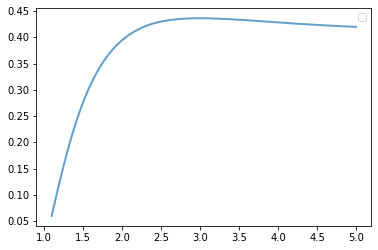

In [77]:
h = np.linspace(1.1,5,100)
fig, ax = plt.subplots()
y = g2(1/(1.5*((h-1)/2)**(1/h)),h) - g2(1/(0.5*((h-1)/2)**(1/h)),h)
ax.plot(h, y, linewidth=2,alpha=0.7)
plt.legend()

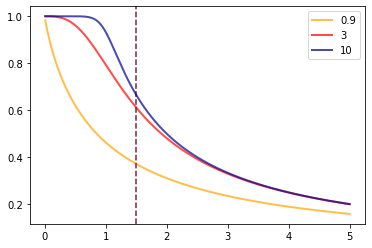

In [10]:
x = np.linspace(0.01,5,1000)
fig, ax = plt.subplots()
for h,c in [(0.9,'orange'),(3,'red'),(10,'darkblue')]:
    y1 = g2(x,h)
    ax.plot(x, y1, linewidth=2,label=f'{h}',color=c,alpha=0.7)
    plt.axvline(x=a,color=c,linestyle='--',alpha=0.5)
plt.legend()

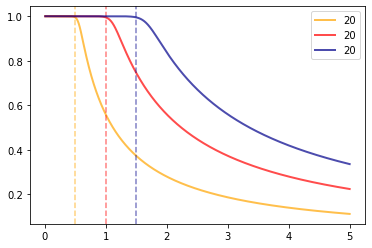

In [73]:
x = np.linspace(0.01,5,1000)
fig, ax = plt.subplots()
h = 20
for a,c in [(0.5,'orange'),(1,'red'),(1.5,'darkblue')]:
    y1 = g2(x/(a*((h-1)/2)**(1/h)),h)
    ax.plot(x, y1, linewidth=2,label=f'{h}',color=c,alpha=0.7)
    plt.axvline(x=a,color=c,linestyle='--',alpha=0.5)
plt.legend()

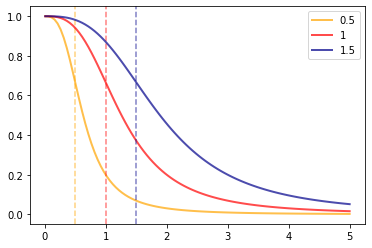

In [5]:
x = np.linspace(0.01,5,100)
fig, ax = plt.subplots()
h = 3
H = ((h-1)/(h+1))**(-1/h)
for a,c in [(0.5,'orange'),(1,'red'),(1.5,'darkblue')]:
    y1 = (x/(H*a*1))**(-h)/((x/(H*a*1))**(-h)+1)
    ax.plot(x, y1, linewidth=2,label=f'{a}',color=c,alpha=0.7)
    plt.axvline(x=a*1,color=c,linestyle='--',alpha=0.5)
plt.legend()

REAL DATA

In [4]:
BB_data = pd.read_csv(f"../../bases/treated_BB_test.csv")

BB_data = BB_data.sort_values(by=['BE_id','siret','nb'])

BB_data = BB_data.query(f'rome in {romes}')

DE_data = pd.read_csv(f"../../bases/treated_DE_test.csv")

DE_data = DE_data.query(f'rome in {romes}')

BE = BB_data.BE_id.unique().tolist()

BE = BE[0:5]

In [5]:
t = [8,4]

mH, mL, d = 1.5, 0.5, 6

comb = [((rho_equiv(mH,mL,b,d)),(rho_equiv(mH,mL,b,d)),
         ((mL,b),(mH,b))) for b in [3]]

In [13]:
results = {}

method = Method(correct_alpha=True,draws='recall',opt='nelder-mead',var=True)

for i, (rho_DE, rho_BB, m) in enumerate(comb):
    
    results[i] = {}
    
    results[i]['param'] = comb[i]
    
    for be in BE: 
        
        print(f'{i+1} for be = {be}')
        
        DE = gen_DE(DE_data.loc[DE_data.BE_id == be],rho_DE,t)
               
        BRANCHES, FIRMS = gen_BB(BB_data.loc[BB_data.BE_id == be],rho_BB,m)
        
        MAT = Matrices(distance,DE,BRANCHES)

        results[i][be] = minimize(lambda beta: -get_matches(beta,MAT,DE,BRANCHES,method),np.array([0,0,0]),method=method.opt) 
        
        print(results[i][be].x)

save_results = {v:[] for v in ['BE_id','d','rho*d','m','gamma','equiv_d','rhoH','rhoL']}

for i, (rho_DE, rho_BB, m) in enumerate(comb):
    
    for be in BE:
        
        save_results['BE_id'].append(be)
        
        save_results['d'].append(results[i][be].x[0])
        
        save_results['rho*d'].append(results[i][be].x[1])
        
        save_results['m'].append(results[i][be].x[2])
        
        #save_results['theta'].append(results[i][be].x[3])
        
        #save_results['h'].append(results[i][be].x[4])
        
        save_results['gamma'].append(m[0][1])
        
        save_results['equiv_d'].append(d)
        
        save_results['rhoH'].append(rho_BB[0])
        
        save_results['rhoL'].append(rho_BB[1])
        
pd.DataFrame(save_results).to_csv("../../bases/results_small.csv",index = False)

1 for be = 103
[-2.92529284  2.81916583  1.08360962]
1 for be = 2411
[-5.53017255  6.16290647  0.56908306]
1 for be = 2713
[-6.42276534  6.41231595  1.26781011]
1 for be = 4408
[-4.66300595  4.531519    1.33146957]
1 for be = 5321
[-18.22022272  22.14052266   0.85902189]


In [6]:
saved_results = pd.read_csv("../../bases/results_small.csv")

param = saved_results[['gamma','equiv_d']].drop_duplicates().reset_index()

results = {}

for i,p in param.iterrows(): 
    
    results[i] = {}
    
    results[i]['param'] = {'gamma' : p.gamma, 'equiv_d' : p.equiv_d}
    
    results[i]['betas'] = {row['BE_id']:np.array([row['d'],row['rho*d'],row['m']]) for j,row in saved_results.loc[saved_results.gamma == p.gamma].loc[saved_results.equiv_d == p.equiv_d].iterrows()}
    

In [9]:
method = Method(correct_alpha=False,draws='recall',opt='Nelder-Mead',var=True)

for i in results.keys():

    out = init_output()
    
    m = [(1.5,results[i]['param']['gamma']),(0.5,results[i]['param']['gamma'])]

    rho_DE = rho_equiv(1.5,0.5,results[i]['param']['gamma'],results[i]['param']['equiv_d'])
    
    rho_BB = rho_equiv(1.5,0.5,results[i]['param']['gamma'],results[i]['param']['equiv_d'])

    #RS, MATS = [], []

    for be in BE:
        
        print(f'{i+1} for be = {be}')
        
        DE = gen_DE(DE_data.loc[DE_data.BE_id == be],rho_DE,t)
               
        BRANCHES, FIRMS = gen_BB(BB_data.loc[BB_data.BE_id == be],rho_BB,m)
        
        MAT = Matrices(distance,DE,BRANCHES)
    
        #MATS.append(MAT)
          
        R = recommendations(results[i]['betas'][be],MAT,DE,BRANCHES,method)
    
        print(stat_des(R,DE,BRANCHES,m,rho_DE,rho_BB))

        #RS.append(R)
    
        out = append_output(out,R,MAT,DE,BRANCHES) 
        
    transform(out)
    
    run_reg(results[i],out)
        
    #pd.DataFrame(out).to_csv(f"../../bases/out_{i}.csv",index = False)

1 for be = 103
{'d_DE': {0.85: [2.05, 2464.0], 0.42: [1.29, 2404.0]}, 'd_BB': {0.85: [2.99, 1917.0], 0.42: [0.82, 2951.0]}, 'nb_BB': {(1.5, 3): [270.39, 15.0], (0.5, 3): [115.0, 26.0]}}
1 for be = 2411
{'d_DE': {0.85: [1.62, 4600.0], 0.42: [0.64, 4648.0]}, 'd_BB': {0.85: [1.54, 6339.0], 0.42: [0.24, 2909.0]}, 'nb_BB': {(1.5, 3): [87.5, 59.0], (0.5, 3): [94.07, 53.0]}}
1 for be = 2713
{'d_DE': {0.85: [1.13, 5060.0], 0.42: [0.49, 5120.0]}, 'd_BB': {0.85: [1.12, 6679.0], 0.42: [0.2, 3501.0]}, 'nb_BB': {(1.5, 3): [64.17, 114.0], (0.5, 3): [26.18, 157.0]}}
1 for be = 4408
{'d_DE': {0.85: [1.36, 3920.0], 0.42: [0.77, 4032.0]}, 'd_BB': {0.85: [1.42, 5334.0], 0.42: [0.32, 2618.0]}, 'nb_BB': {(1.5, 3): [106.63, 75.0], (0.5, 3): [34.39, 71.0]}}
1 for be = 5321
{'d_DE': {0.85: [0.57, 7396.0], 0.42: [0.24, 7256.0]}, 'd_BB': {0.85: [0.62, 9385.0], 0.42: [0.03, 5267.0]}, 'nb_BB': {(1.5, 3): [51.07, 223.0], (0.5, 3): [26.42, 197.0]}}


/Users/thomaszuber/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


In [35]:
for i in results.keys():
    print(i,results[i]['t'])

0 {'rho_DE': 94.01385556497041, 'rho_BB': 65.84331323395577, 'm_BB': 11.67755188710161}


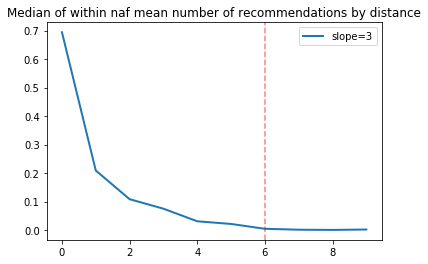

In [11]:
fig, ax = plt.subplots()
for i in results.keys():
    ax.plot(results[i]['sum_treat']['R_bb_d'][0].index,
            results[i]['sum_treat']['R_bb_d'][0], 
            linewidth=2,
            label=f"slope={results[i]['param']['gamma']}")
ax.legend()
ax.set_title('Median of within naf mean number of recommendations by distance')
plt.axvline(x=d,color='red',linestyle='--',alpha=0.5)

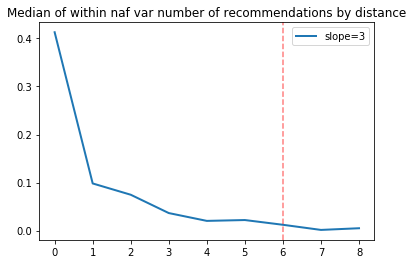

In [12]:
fig, ax = plt.subplots()
for i in results.keys():
    ax.plot(results[i]['sum_treat']['R_bb_d'][1].index,
            results[i]['sum_treat']['R_bb_d'][1], 
            linewidth=2,
            label=f"slope={results[i]['param']['gamma']}")
ax.legend()
ax.set_title('Median of within naf var number of recommendations by distance')
plt.axvline(x=d,color='red',linestyle='--',alpha=0.5)

In [13]:
import seaborn as sns

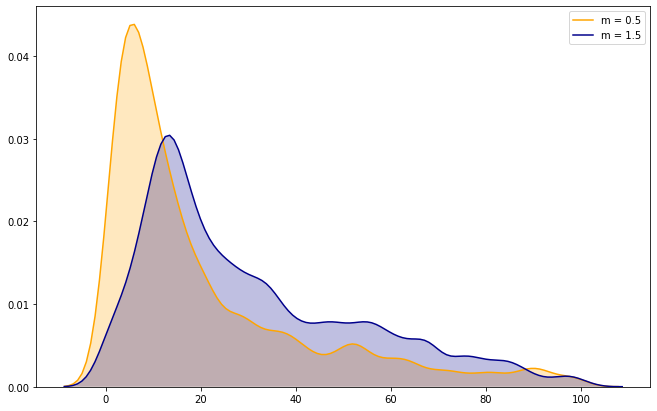

In [14]:
m_BB = out.m_BB.unique().tolist()
fig, ax = plt.subplots(figsize=(11,7))
sns.kdeplot(out.query(f'm_BB == {m_BB[1]}')[['siret','R']].drop_duplicates().R, color = 'orange',bw=3,ax=ax,clip=(0,100),shade=True)
sns.kdeplot(out.query(f'm_BB == {m_BB[0]}')[['siret','R']].drop_duplicates().R, color = 'darkblue',bw=3,ax=ax,clip=(0,100),shade=True)
ax.legend([f'm = {m_BB[1]}',f'm = {m_BB[0]}'])

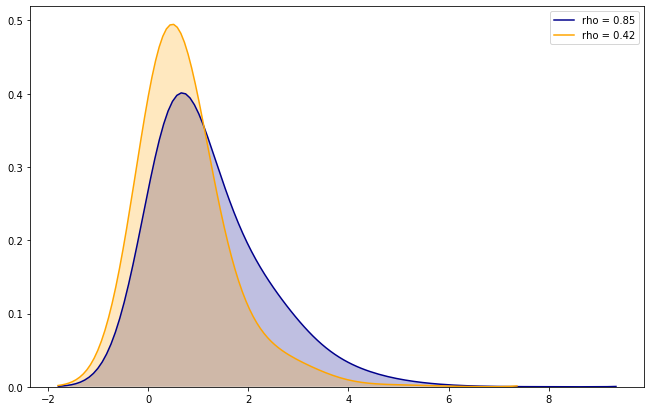

In [32]:
rho_BB = out.rho_BB.unique().tolist()
fig, ax = plt.subplots(figsize=(11,7))
sns.kdeplot(out.query(f'rho_BB == {rho_BB[1]}').d, color = 'darkblue',bw=0.6,ax=ax,clip=(0,10),shade=True)
sns.kdeplot(out.query(f'rho_BB == {rho_BB[0]}').d, color = 'orange',bw=0.6,ax=ax,clip=(0,10),shade=True)
ax.legend([f'rho = {rho_BB[1]}',f'rho = {rho_BB[0]}'])

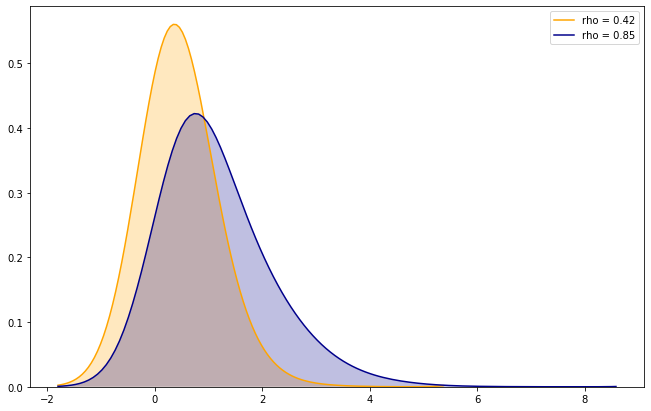

In [40]:
rho_DE = out.rho_DE.unique().tolist()
fig, ax = plt.subplots(figsize=(11,7))
sns.kdeplot(out.query(f'rho_DE == {rho_DE[1]}').d_res, color = 'orange',bw=0.6,ax=ax,clip=(0,10),shade=True)
sns.kdeplot(out.query(f'rho_DE == {rho_DE[0]}').d_res, color = 'darkblue',bw=0.6,ax=ax,clip=(0,10),shade=True)
ax.legend([f'rho = {rho_DE[1]}',f'rho = {rho_DE[0]}'])

SIMULATE RESULTS AND POWER CALCULATIONS

In [281]:
rd.seed(123)

t = [8,4]

mH, mL, d = 1.5, 0.5, 6
comb = [((rho_equiv(mH,mL,b,d)),(rho_equiv(mH,mL,b,d)),
         ((mL,b),(mH,b))) for b in [10]]

method = Method(correct_alpha=True,draws='recall',opt='Nelder-Mead',var=True)

DES, BRANCHESS, MATS, RS = [], [], [], []

Betas, Vars = {}, {}

SEED = rd.randint(1,high=len(comb)*1000,size=len(comb))

for i, (rho_DE, rho_BB, m) in enumerate(comb):
    
    for be in BE:
        
        print(f'{i} for be = {be}')
        
        DE = gen_DE(DE_data.loc[DE_data.BE_id == be],rho_DE,t)
        
        DES.append(DE)
               
        BRANCHES, FIRMS = gen_BB(BB_data.loc[BB_data.BE_id == be],rho_BB,m)
        
        BRANCHESS.append(BRANCHES)
        
        MAT = Matrices(distance,DE,BRANCHES)
            
        MATS.append(MAT)

        res = minimize(lambda beta: -get_matches(beta,MAT,DE,BRANCHES,method),\
                        np.array([1,1,-1]),method=method.opt) 
        
        R = recommendations(res.x,MAT,DE,BRANCHES,method)
        
        RS.append(R)

    Betas[i], Vars[i] = bootstrap(RS,MATS,DES,BRANCHESS,nb_iter=100,seed=SEED[i])

0 for be = 103
0 for be = 2411
0 for be = 2713
0 for be = 4408
0 for be = 5321
0 for be = 7523
0 for be = 7622
0 for be = 8451
0 for be = 9408
0 for be = 9410
0 out of 100 bootstraps
1 out of 100 bootstraps
2 out of 100 bootstraps
3 out of 100 bootstraps
4 out of 100 bootstraps
5 out of 100 bootstraps
6 out of 100 bootstraps
7 out of 100 bootstraps
8 out of 100 bootstraps
9 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


10 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning

11 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


12 out of 100 bootstraps
13 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


14 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


15 out of 100 bootstraps
16 out of 100 bootstraps
17 out of 100 bootstraps
18 out of 100 bootstraps
19 out of 100 bootstraps
20 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


21 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


22 out of 100 bootstraps
23 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning

24 out of 100 bootstraps
25 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning

26 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning

27 out of 100 bootstraps
28 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


29 out of 100 bootstraps
30 out of 100 bootstraps
31 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


32 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


33 out of 100 bootstraps
34 out of 100 bootstraps
35 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


36 out of 100 bootstraps
37 out of 100 bootstraps
38 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


39 out of 100 bootstraps
40 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


41 out of 100 bootstraps
42 out of 100 bootstraps
43 out of 100 bootstraps
44 out of 100 bootstraps
45 out of 100 bootstraps
46 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


47 out of 100 bootstraps
48 out of 100 bootstraps
49 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


50 out of 100 bootstraps
51 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning

52 out of 100 bootstraps
53 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


54 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


55 out of 100 bootstraps
56 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


57 out of 100 bootstraps
58 out of 100 bootstraps
59 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


60 out of 100 bootstraps
61 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


62 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


63 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


64 out of 100 bootstraps
65 out of 100 bootstraps
66 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


67 out of 100 bootstraps
68 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning

69 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning

70 out of 100 bootstraps
71 out of 100 bootstraps
72 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


73 out of 100 bootstraps
74 out of 100 bootstraps
75 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning

76 out of 100 bootstraps
77 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


78 out of 100 bootstraps
79 out of 100 bootstraps
80 out of 100 bootstraps
81 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


82 out of 100 bootstraps
83 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


84 out of 100 bootstraps
85 out of 100 bootstraps
86 out of 100 bootstraps
87 out of 100 bootstraps
88 out of 100 bootstraps
89 out of 100 bootstraps
90 out of 100 bootstraps
91 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning

92 out of 100 bootstraps
93 out of 100 bootstraps
94 out of 100 bootstraps
95 out of 100 bootstraps
96 out of 100 bootstraps
97 out of 100 bootstraps


/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning

98 out of 100 bootstraps
99 out of 100 bootstraps


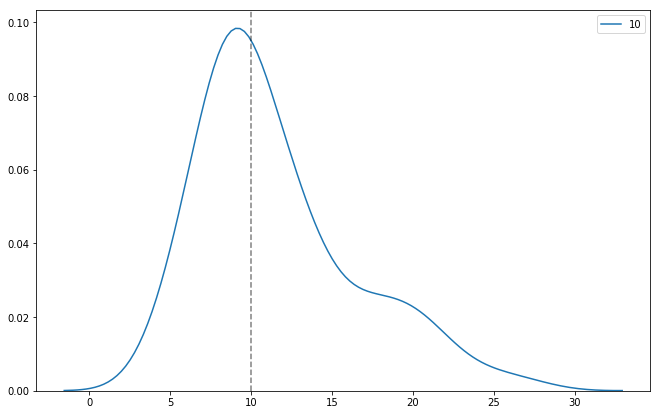

In [282]:
s
for i,beta in Betas.items():
    sns.kdeplot(beta['m0'],bw=2,ax=ax,shade=False,label=f'{comb[i][2][0][1]}')
plt.axvline(x=true_param[2],color='black',linestyle='--',alpha=0.5)